# Imports

In [1]:
# %%capture

!pip install category_encoders

In [1]:
import warnings; 
warnings.simplefilter('ignore')

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)

from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

import category_encoders as ce
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess, Fourier
import scipy as sp
import scipy.fftpack
# from fbprophet import Prophet
from prophet import Prophet
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler 

# Task 1 (40 points)

* EDA (10 points)
* Explain general setup of feature engineering (10 points)
* Use of scientific literature supporting the setup (5 points)
* Rationale for choice of final attributes (15 points)

In [3]:
df = pd.read_csv('data/mood.csv')
df['time'] = pd.to_datetime(df['time'])
df.head()

Unnamed: 0       id                time variable  value
0           1  AS14.01 2014-02-26 13:00:00     mood    6.0
1           2  AS14.01 2014-02-26 15:00:00     mood    6.0
2           3  AS14.01 2014-02-26 18:00:00     mood    6.0
3           4  AS14.01 2014-02-26 21:00:00     mood    7.0
4           5  AS14.01 2014-02-27 09:00:00     mood    6.0

## EDA and preprocessing

In [5]:
profile = ProfileReport(df, title="Pandas Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

We see that the column value contains potential outliers

### What are the dates of the experiment

In [6]:
df.id.nunique()

27

In [7]:
df.groupby('id')['time'].agg(['min', 'max']).sort_values(['min'])

min                     max
id                                                     
AS14.02 2014-02-17 07:00:52.197 2014-04-25 21:00:00.000
AS14.06 2014-02-17 07:12:13.631 2014-05-08 09:00:00.000
AS14.14 2014-02-17 07:49:19.635 2014-05-05 15:00:00.000
AS14.17 2014-02-17 08:57:16.313 2014-05-05 15:00:00.000
AS14.19 2014-02-17 08:58:58.471 2014-05-05 18:00:00.000
AS14.28 2014-02-17 09:48:49.536 2014-05-08 13:37:16.006
AS14.20 2014-02-17 09:52:02.075 2014-05-05 13:00:00.000
AS14.26 2014-02-17 09:58:59.766 2014-05-30 21:00:00.000
AS14.29 2014-02-17 10:42:05.661 2014-05-15 12:00:00.000
AS14.09 2014-02-17 10:47:29.664 2014-05-05 12:00:00.000
AS14.16 2014-02-17 11:18:33.513 2014-05-05 15:00:00.000
AS14.25 2014-02-17 11:50:46.069 2014-05-08 14:00:00.000
AS14.01 2014-02-17 12:04:42.394 2014-05-05 10:00:00.000
AS14.08 2014-02-17 12:51:38.029 2014-05-05 15:00:00.000
AS14.23 2014-02-17 14:31:48.654 2014-05-04 02:52:14.772
AS14.15 2014-02-17 14:45:29.710 2014-05-08 12:00:00.000
AS14.27 2014-02-17 14:51:54.355 2014-05-15 12:00:00.000
AS14.33 2014-02-17 15:52:18.940 2014-05-31 12:00:00.000
AS14.03 2014-02-17 16:28:23.000 2014-05-08 05:00:00.000
AS14.32 2014-02-17 17:56:16.114 2014-05-14 20:00:00.000
AS14.13 2014-02-17 19:18:22.612 2014-05-04 02:00:00.000
AS14.30 2014-02-17 20:38:00.928 2014-05-05 15:00:00.000
AS14.31 2014-02-17 21:54:40.516 2014-05-17 05:00:00.000
AS14.05 2014-02-18 13:07:45.496 2014-05-05 15:00:00.000
AS14.12 2014-02-19 17:30:36.497 2014-05-05 18:00:00.000
AS14.07 2014-03-17 21:03:46.401 2014-05-05 20:00:00.000
AS14.24 2014-04-09 10:47:41.782 2014-06-09 00:00:00.000

Most of the participants started at the same time. The experiment lasted for a bit more than 2 months. A couple of participants started 1+ month later. Our guess is that the students are from NL and all live in the same timezone

### What are the values for different kinds of interaction with the device

In [8]:
df.groupby(['variable'])['value'].agg(['min', 'max'])

min        max
variable                                  
activity                  0.000      1.000
appCat.builtin       -82798.871  33960.246
appCat.communication      0.006   9830.777
appCat.entertainment     -0.011  32148.677
appCat.finance            0.131    355.513
appCat.game               1.003   5491.793
appCat.office             0.003  32708.818
appCat.other              0.014   3892.038
appCat.social             0.094  30000.906
appCat.travel             0.080  10452.615
appCat.unknown            0.111   2239.937
appCat.utilities          0.246   1802.649
appCat.weather            1.003    344.863
call                      1.000      1.000
circumplex.arousal       -2.000      2.000
circumplex.valence       -2.000      2.000
mood                      1.000     10.000
screen                    0.035   9867.007
sms                       1.000      1.000

1. call, sms appear only when there is a fact of this action, so there are no zeros.  
2. the duration of the call may be approximately calculated from the next event (rarely possible).  
3. activity is the value collected hourly. mean sth like the percentage ratio of the hour when the user was active.  
4. mood and circumplex are discrete
5. all the others mean the number of seconds spent on each of the activities

TODO:
1. All activities sum to the screen time
2. Add blink screen usages as a feature

### Outliers

In [9]:
df['variable'].unique()

array(['mood', 'circumplex.arousal', 'circumplex.valence', 'activity',
       'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather'],
      dtype=object)

In [10]:
df[(df['variable'].str.contains('app')) & (df['value'] < 0)]

Unnamed: 0       id                    time              variable  \
150040      151512  AS14.02 2014-03-16 15:46:43.769        appCat.builtin   
159972      622771  AS14.07 2014-04-30 14:18:06.200        appCat.builtin   
162154      754571  AS14.12 2014-04-02 16:42:16.523        appCat.builtin   
309805      484694  AS14.02 2014-03-26 21:18:45.144  appCat.entertainment   

            value  
150040    -44.689  
159972 -82798.871  
162154     -1.218  
309805     -0.011

#### appCat.builtin

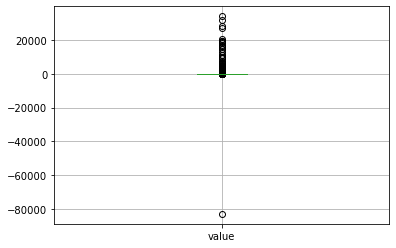

In [11]:
df[df['variable'] == 'appCat.builtin'].boxplot(column=['value']);

In [12]:
df[(df['variable'] == 'appCat.builtin')&(df['value'] < 0)]

Unnamed: 0       id                    time        variable      value
150040      151512  AS14.02 2014-03-16 15:46:43.769  appCat.builtin    -44.689
159972      622771  AS14.07 2014-04-30 14:18:06.200  appCat.builtin -82798.871
162154      754571  AS14.12 2014-04-02 16:42:16.523  appCat.builtin     -1.218

In [13]:
df.shape

(376912, 5)

In [14]:
df.drop(df[(df['variable'] == 'appCat.builtin')&(df['value'] < 0)].index, axis=0, inplace=True)
df.shape

(376909, 5)

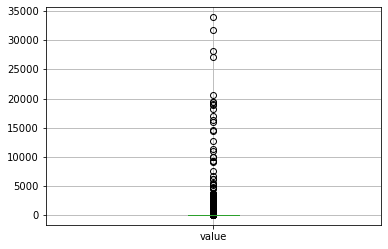

In [15]:
df[df['variable'] == 'appCat.builtin'].boxplot(column=['value']);

In [16]:
# df[df['value'] == df[df['variable'] == 'appCat.builtin'].agg({'value': ['min', 'max']})]

#### appCat.entertainment

In [17]:
df[(df['variable'] == 'appCat.entertainment') & (df['value'] < 0)]

Unnamed: 0       id                    time              variable  \
309805      484694  AS14.02 2014-03-26 21:18:45.144  appCat.entertainment   

        value  
309805 -0.011

In [18]:
df.drop(309805, axis=0, inplace=True)
df.shape

(376908, 5)

#### appCat.office

In [19]:
df[(df['variable'] == 'appCat.office') & (df['value'] > 5000)]

Unnamed: 0       id                    time       variable      value
340707     1356866  AS14.29 2014-04-19 23:15:02.463  appCat.office  32708.818
342284     1360733  AS14.29 2014-05-03 12:34:14.911  appCat.office   5691.982

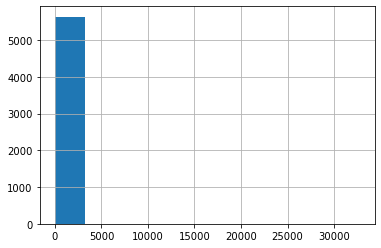

In [20]:
df[df['variable'] == 'appCat.office']['value'].hist();

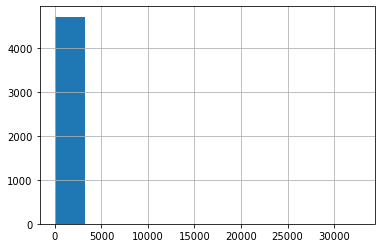

In [21]:
df[(df['id'] == 'AS14.29') & (df['variable'] == 'appCat.office')]['value'].hist();

33k seconds is about 9 hours. In general (and for this subject as well), we see that the time spent in the office apps is significantly smaller so we treat this case as a forgotten opened app

In [22]:
df.drop(340707, axis=0, inplace=True)
df.shape

(376907, 5)

### Activity. Can it be a proxy for sleep? 

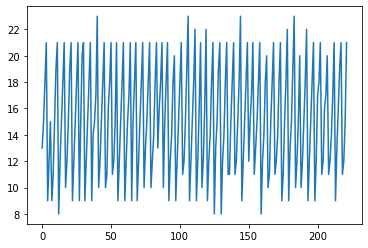

In [23]:
df[(df['id'] == 'AS14.01') & (df['variable'] == 'mood')].sort_values(['time'])['time'].dt.hour.plot();

In [24]:
sorted(df[(df['id'] == 'AS14.01') & (df['variable'] == 'mood')].sort_values(['time'])['time'].dt.hour.unique())

[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

<Figure size 1224x864 with 0 Axes>

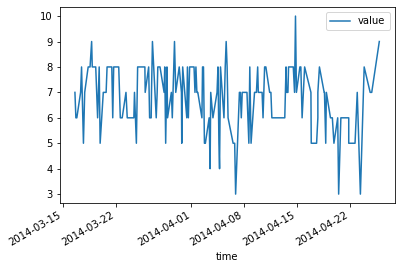

In [25]:
plt.figure(figsize=(17, 12));
df[(df['id'] == 'AS14.02') & (df['variable'] == 'mood')].sort_values(['time']).plot('time', 'value');

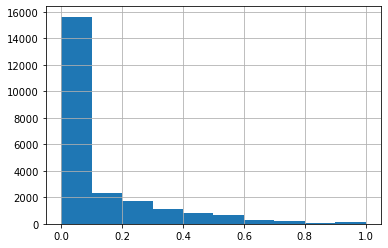

In [26]:
df[df['variable'] == 'activity']['value'].hist();

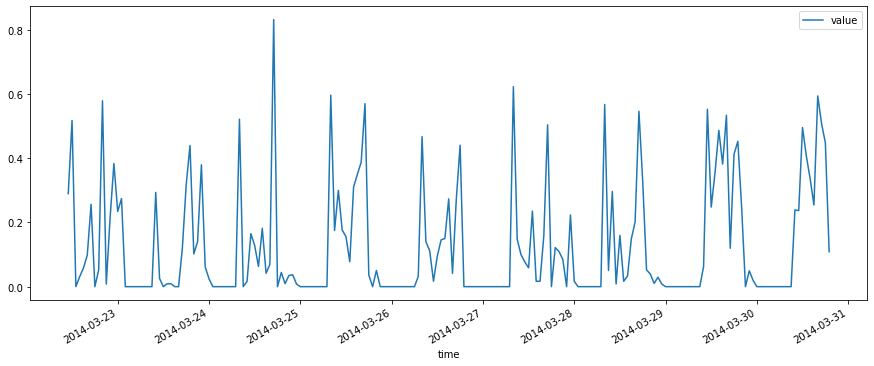

In [27]:
df[(df['id'] == 'AS14.03') & (df['variable'] == 'activity')].sort_values(['time']).head(200).plot(x='time', y='value', figsize=(15,6));

TODO: 
1. add a binary (sth else) feature for sleep\not. sleep should be mutually exclusive with mood records
    1. continous period of 5+ hours
    2. correct it with surrounding events 
2. for each of the users use 75% percentile as sports

### Was the circumplex collected at the same time as the mood?

In [28]:
Image(url= "images/circumplex_model.png", width=400, height=400)

In [29]:
targets_num_df = df[df['variable'].isin(['mood', 'circumplex.valence', 'circumplex.arousal'])].\
    groupby(['id', 'time'])['variable'].unique()
targets_num_df.head()

id       time               
AS14.01  2014-02-26 13:00:00    [mood, circumplex.arousal, circumplex.valence]
         2014-02-26 15:00:00    [mood, circumplex.arousal, circumplex.valence]
         2014-02-26 18:00:00    [mood, circumplex.arousal, circumplex.valence]
         2014-02-26 21:00:00    [mood, circumplex.arousal, circumplex.valence]
         2014-02-27 09:00:00    [mood, circumplex.arousal, circumplex.valence]
Name: variable, dtype: object

In [30]:
targets_num_df[targets_num_df.apply(lambda x: len(x)) != 3]

Series([], Name: variable, dtype: object)

We don't see the cases when mood, circumplex.arousal, circumplex.valence were collected not at the same time. As they are all logically connected, we may conclude that not only the mood was collected as a target during the experiment, but the circumplex as well. Therefore, we have to treat this carefully as including of circumplex while predicting mood for the same time will have a clear leak

### Do we have the same variable indicated at the same time for the same user?

In [31]:
df.duplicated(['id', 'time', 'variable']).value_counts()

False    376864
True         43
dtype: int64

In [32]:
df[df.duplicated(['id', 'time', 'variable'], keep=False)]

Unnamed: 0       id                time            variable  value
135           136  AS14.01 2014-04-17 11:00:00                mood    7.0
136           137  AS14.01 2014-04-17 11:00:00                mood    6.0
358           359  AS14.02 2014-04-17 18:00:00                mood    6.0
359           360  AS14.02 2014-04-17 18:00:00                mood    7.0
371           372  AS14.02 2014-04-21 20:00:00                mood    5.0
372           373  AS14.02 2014-04-21 20:00:00                mood    6.0
937           938  AS14.06 2014-04-13 17:00:00                mood    7.0
938           939  AS14.06 2014-04-13 17:00:00                mood    5.0
1748         1749  AS14.12 2014-03-30 11:00:00                mood    6.0
1749         1750  AS14.12 2014-03-30 11:00:00                mood    7.0
1873         1874  AS14.12 2014-04-25 17:00:00                mood    4.0
1874         1875  AS14.12 2014-04-25 17:00:00                mood    5.0
2669         2670  AS14.16 2014-03-29 20:00:00                mood    7.0
2670         2671  AS14.16 2014-03-29 20:00:00                mood    6.0
3060         3061  AS14.17 2014-05-03 17:00:00                mood    7.0
3061         3062  AS14.17 2014-05-03 17:00:00                mood    8.0
3966         3967  AS14.25 2014-04-27 11:00:00                mood    7.0
3967         3968  AS14.25 2014-04-27 11:00:00                mood    8.0
3996         3997  AS14.25 2014-05-03 15:00:00                mood    7.0
3997         3998  AS14.25 2014-05-03 15:00:00                mood    6.0
4616         4617  AS14.28 2014-04-16 17:00:00                mood    6.0
4617         4618  AS14.28 2014-04-16 17:00:00                mood    4.0
4635         4636  AS14.28 2014-04-20 17:00:00                mood    9.0
4636         4637  AS14.28 2014-04-20 17:00:00                mood    7.0
5527         5528  AS14.33 2014-05-05 14:00:00                mood    6.0
5528         5529  AS14.33 2014-05-05 14:00:00                mood    8.0
5776         5777  AS14.01 2014-04-17 11:00:00  circumplex.arousal   -1.0
5777         5778  AS14.01 2014-04-17 11:00:00  circumplex.arousal   -2.0
5828         5829  AS14.01 2014-04-27 20:00:00  circumplex.arousal    0.0
5829         5830  AS14.01 2014-04-27 20:00:00  circumplex.arousal    1.0
6000         6001  AS14.02 2014-04-17 18:00:00  circumplex.arousal    1.0
6001         6002  AS14.02 2014-04-17 18:00:00  circumplex.arousal    0.0
6013         6014  AS14.02 2014-04-21 20:00:00  circumplex.arousal    1.0
6014         6015  AS14.02 2014-04-21 20:00:00  circumplex.arousal   -2.0
6225         6226  AS14.03 2014-05-03 11:00:00  circumplex.arousal    0.0
6226         6227  AS14.03 2014-05-03 11:00:00  circumplex.arousal   -1.0
6580         6581  AS14.06 2014-04-13 17:00:00  circumplex.arousal   -1.0
6581         6582  AS14.06 2014-04-13 17:00:00  circumplex.arousal   -2.0
7391         7392  AS14.12 2014-03-30 11:00:00  circumplex.arousal   -1.0
7392         7393  AS14.12 2014-03-30 11:00:00  circumplex.arousal   -1.0
7516         7517  AS14.12 2014-04-25 17:00:00  circumplex.arousal    0.0
7517         7518  AS14.12 2014-04-25 17:00:00  circumplex.arousal    1.0
8973         8974  AS14.20 2014-03-31 17:00:00  circumplex.arousal    1.0
8974         8975  AS14.20 2014-03-31 17:00:00  circumplex.arousal    0.0
9399         9400  AS14.24 2014-05-11 11:00:00  circumplex.arousal    0.0
9400         9401  AS14.24 2014-05-11 11:00:00  circumplex.arousal   -2.0
9609         9610  AS14.25 2014-04-27 11:00:00  circumplex.arousal    0.0
9610         9611  AS14.25 2014-04-27 11:00:00  circumplex.arousal    1.0
10258       10259  AS14.28 2014-04-16 17:00:00  circumplex.arousal    1.0
10259       10260  AS14.28 2014-04-16 17:00:00  circumplex.arousal    1.0
10277       10278  AS14.28 2014-04-20 17:00:00  circumplex.arousal    1.0
10278       10279  AS14.28 2014-04-20 17:00:00  circumplex.arousal   -1.0
10371       10372  AS14.29 2014-04-06 11:00:00  circumplex.arousal   -1.0
10372      

In [33]:
df[df['variable'] == 'mood']['value'].unique()

array([ 6.,  7.,  5.,  8.,  9.,  4.,  3., 10.,  2.,  1.])

we see the duplicates. probably, they mean fractions (6.5, 0.5 etc)  
TODO Ned: find evidence

In [34]:
df = df.groupby(['id', 'time', 'variable']).mean().reset_index()
df.shape

(376864, 5)

In [35]:
df[(df['id'] == 'AS14.01') & (df['time'] == '2014-04-17 11:00:00')]

id                time            variable  Unnamed: 0    value
14145  AS14.01 2014-04-17 11:00:00            activity     17559.0  0.05042
14146  AS14.01 2014-04-17 11:00:00  circumplex.arousal      5777.5 -1.50000
14147  AS14.01 2014-04-17 11:00:00  circumplex.valence     11420.5  0.50000
14148  AS14.01 2014-04-17 11:00:00                mood       136.5  6.50000

the unnamed (index) is weird

## Feature engineering non-dependent on train-test split

time may be encoded with a trigonometrical function to link 23 and 0

In [36]:
# # add day of the week columns
# df['day'] = df['time'].dt.day
# df['dayofweek'] = df['time'].dt.dayofweek
# df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x in [5, 6] else 0)
# df['dayofyear'] = df['time'].dt.dayofyear
# df['quarter'] = df['time'].dt.quarter

In [37]:
# df.head()

id                    time variable  Unnamed: 0  value   day_name  \
0  AS14.01 2014-02-17 12:04:42.394     call    136471.0    1.0     Monday   
1  AS14.01 2014-02-17 18:28:25.520     call    136472.0    1.0     Monday   
2  AS14.01 2014-02-18 09:29:51.257     call    136473.0    1.0    Tuesday   
3  AS14.01 2014-02-19 14:43:30.575     call    136474.0    1.0  Wednesday   
4  AS14.01 2014-02-19 17:29:10.378     call    136475.0    1.0  Wednesday   

   day  dayofweek  is_weekend  dayofyear  quarter  
0   17          0           0         48        1  
1   17          0           0         48        1  
2   18          1           0         49        1  
3   19          2           0         50        1  
4   19          2           0         50        1

In [38]:
# time_cols = ['day', 'dayofweek', 'is_weekend', 'dayofyear', 'quarter']

check the timing(hour) distribution across the days

don't forget to try find their local times (the first measurement is done in the morning)

## Pivoting data from the previous days as features

## Aggregating, Pivoting and feature engineering

In the data aggregation and preprocessing we first round the time to hours and create a pivot table, missing timestamps are filled in with rows of NaN. 

In [4]:
# pivot and fill missing timestamps
df['time'] = df['time'].dt.floor('H')
pivoted_df = pd.pivot_table(df, values='value',
                            index=['id', 'time'],
                            columns='variable').reset_index()
df_list = []
for idx in pivoted_df['id'].unique():
    idx_mask = pivoted_df['id'] == idx
    
    df_missing_data = pd.DataFrame()
    start, end = pivoted_df[idx_mask]['time'].agg(['min', 'max'])
    
    df_missing_data['time'] = pd.date_range(start, end, freq="60min").difference(
        pivoted_df[idx_mask]['time'])
    df_missing_data['id'] = idx

    df_list.append(pd.concat([pivoted_df[idx_mask], df_missing_data]))

pivoted_df = pd.concat(df_list, axis=0).sort_values(['id', 'time'])
pivoted_df.head()

id                time  activity  appCat.builtin  \
0  AS14.01 2014-02-17 12:00:00       NaN             NaN   
0  AS14.01 2014-02-17 13:00:00       NaN             NaN   
1  AS14.01 2014-02-17 14:00:00       NaN             NaN   
2  AS14.01 2014-02-17 15:00:00       NaN             NaN   
3  AS14.01 2014-02-17 16:00:00       NaN             NaN   

   appCat.communication  appCat.entertainment  appCat.finance  appCat.game  \
0                   NaN                   NaN             NaN          NaN   
0                   NaN                   NaN             NaN          NaN   
1                   NaN                   NaN             NaN          NaN   
2                   NaN                   NaN             NaN          NaN   
3                   NaN                   NaN             NaN          NaN   

   appCat.office  appCat.other  appCat.social  appCat.travel  appCat.unknown  \
0            NaN           NaN            NaN            NaN             NaN   
0            NaN           NaN            NaN            NaN             NaN   
1            NaN           NaN            NaN            NaN             NaN   
2            NaN           NaN            NaN            NaN             NaN   
3            NaN           NaN            NaN            NaN             NaN   

   appCat.utilities  appCat.weather  call  circumplex.arousal  \
0               NaN             NaN   1.0                 NaN   
0               NaN             NaN   NaN                 NaN   
1               NaN             NaN   NaN                 NaN   
2               NaN             NaN   NaN                 NaN   
3               NaN             NaN   NaN                 NaN   

   circumplex.valence  mood  screen  sms  
0                 NaN   NaN     NaN  NaN  
0                 NaN   NaN     NaN  NaN  
1                 NaN   NaN     NaN  NaN  
2                 NaN   NaN     NaN  NaN  
3                 NaN   NaN     NaN  NaN

In [5]:
pivoted_df.id.value_counts()

AS14.33    2470
AS14.26    2461
AS14.31    2121
AS14.29    2091
AS14.27    2087
AS14.32    2068
AS14.28    1925
AS14.25    1924
AS14.06    1923
AS14.15    1919
AS14.03    1910
AS14.19    1859
AS14.14    1857
AS14.17    1856
AS14.20    1853
AS14.16    1853
AS14.08    1852
AS14.09    1851
AS14.01    1847
AS14.30    1844
AS14.05    1827
AS14.23    1813
AS14.13    1808
AS14.12    1802
AS14.02    1623
AS14.24    1455
AS14.07    1176
Name: id, dtype: int64

3 features are extracted from the "activity" column:

1. asleep: has a value of 1 for rows with activity = 0 and 0 elsewhere\
2. active: has a value of 1 for rows with activity > 0.5 and 0 elsewhere\
3. missing_hour: has a value of 1 for rows with activity = NaN, 0 elsewhere

In [6]:
# add binary column for sleep (no activity)
pivoted_df.loc[pivoted_df['activity'] == 0,'asleep'] = 1
pivoted_df['asleep'].fillna(0, inplace=True)

# add binary column for high activity
pivoted_df.loc[pivoted_df['activity'] > 0.5,'active'] = 1
pivoted_df['active'].fillna(0, inplace=True)

# add binary column for missing entry (activity value should be present for every hour)
pivoted_df.loc[pivoted_df['activity'].isna(),'missing_hour'] = 1
pivoted_df['missing_hour'].fillna(0, inplace=True)

In [7]:
# aggregate per mood entry
'''
pivoted_df['id_next'] = pivoted_df['id'].shift(-1)
cols = ['activity', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'call', 'screen', 'sms']

empty_row = pivoted_df.iloc[0][cols].fillna(0)*0
current_sum = pivoted_df.iloc[0][cols].fillna(0)*0
for i,row in pivoted_df.fillna(0).iterrows():
    if row['id'] == row['id_next']:
        current_sum += row[cols]
    else:
        current_sum = pivoted_df.iloc[0][cols].fillna(0)*0
        
    if row['mood'] != 0.:
        pivoted_df.loc[i,cols] = current_sum[cols]
        current_sum = pivoted_df.iloc[0][cols].fillna(0)*0
        
pivoted_df.drop(pivoted_df[pivoted_df['mood'].isna() == True].index, inplace=True)
pivoted_df.drop('id_next', axis=1,inplace=True)
''';

Next we round the time to days and calculate the mood change of a user during a day by subtracting the last mood entry from the first on a given day and saved in the column mood_change.

In [8]:
# calculate the mood change for the previous day
pivoted_df['time'] = pivoted_df['time'].dt.floor('D')

In [9]:

first = pd.DataFrame(pivoted_df.loc[~pivoted_df['mood'].isna()].groupby(['id', 'time'])['mood'].first())
last = pd.DataFrame(pivoted_df.loc[~pivoted_df['mood'].isna()].groupby(['id', 'time'])['mood'].last())
mood_change = (first - last)
mood_change.rename(columns={'mood': 'mood_change'}, inplace=True)

Then data is aggregated daily, group by "id" and "time", and apply different aggregation functions to the columns:\
* take mean: "mood", "circumplex.arousal", "circumplex.valence"\
* take sum: all other columns

In [10]:
# aggregate daily (different agg func for different columns)
# calculate mean for mood and circumplex
df2 = pivoted_df.groupby(['id', 'time'])[['mood', 'circumplex.arousal', 'circumplex.valence']].mean()  
# calculate sum for everything else
df3 = pivoted_df.loc[:, ~pivoted_df.columns.isin(['mood', 'circumplex.arousal', 'circumplex.valence'])].groupby(['id', 'time']).sum() 
pivoted_df = pd.concat([df2, df3, mood_change], axis=1).reset_index()

In [11]:
pivoted_df.id.value_counts()

AS14.33    104
AS14.26    103
AS14.31     90
AS14.29     88
AS14.27     88
AS14.32     87
AS14.03     81
AS14.06     81
AS14.28     81
AS14.15     81
AS14.25     81
AS14.19     78
AS14.30     78
AS14.20     78
AS14.01     78
AS14.16     78
AS14.14     78
AS14.09     78
AS14.08     78
AS14.17     78
AS14.23     77
AS14.13     77
AS14.05     77
AS14.12     76
AS14.02     68
AS14.24     62
AS14.07     50
Name: id, dtype: int64

Days with missing "mood" value are dropped and so are days with no data for more than 6 hours, signal

In [12]:
# drop days without mood value
pivoted_df.drop(pivoted_df[pivoted_df['mood'].isna()].index, inplace=True)

# drop days with more than 6 hours missing
# pivoted_df.drop(pivoted_df[pivoted_df['missing_hour'] > 6].index, inplace=True)

In [14]:
#pivoted_df.id.value_counts()

Mood from the previous day is saved in the column "mood_prev1", which is achieved by shifting the "mood" and "id" column by 1 row down and rows with NaN or rows where the "id" from the previous day is different than the "id" from the current one are droppped. This process is repeated to get the mood value for the next, the only diffrence is that now values are shifted up by 1 rows.

In [15]:
# add column for mood from previous day and drop rows with no data for previous day
# pivoted_df['mood_prev1'] = pivoted_df['mood'].shift(1)
# pivoted_df['id_prev1'] = pivoted_df['id'].shift(1)
# pivoted_df = pivoted_df[pivoted_df['id_prev1'] == pivoted_df['id']]
# pivoted_df.drop('id_prev1', axis=1, inplace=True)

pivoted_df.sort_values(['id', 'time'], inplace=True)
pivoted_df['prev_mood'] = pivoted_df.groupby('id')['mood'].shift()
pivoted_df['next_mood'] = pivoted_df.groupby('id')['mood'].shift(-1)
pivoted_df.drop(pivoted_df[pivoted_df['next_mood'].isna()].index, inplace=True)

In [16]:
# add column for mood for the next day to be used as target and drop rows with no data for following day
# pivoted_df['mood_next'] = pivoted_df['mood'].shift(-1)
# pivoted_df['id_next'] = pivoted_df['id'].shift(-1)
# pivoted_df = pivoted_df[pivoted_df['id_next'] == pivoted_df['id']]
# pivoted_df.drop('id_next', axis=1, inplace=True)

From the "time" column we extract the number of day on a week (0-6) and add a 4th order fourier series deterministic terms based on the "time" column, resulting in 3 sine and 3 cosine functions, similar to how Facebook Prophet works. This step is important since the weekly seasonality of the mood data is very high, meaning that the day of the week plays an important role in the mood. Sine and cosine functions are continous, which helps linear regression to fit the dataset better than the discrete day of the week number, which is expected to work better for decision trees.

Fitting deterministic terms fourier series based on calendar time is common practice, supported by many scientific papers:\
https://www.sciencedirect.com/science/article/pii/S2211467X20300778 \
https://www.tandfonline.com/doi/abs/10.1198/jasa.2011.tm09771

In [17]:
# Estimating weekly seasonality with partial fourier sum
# https://medium.com/analytics-vidhya/how-does-prophet-work-part-2-c47a6ceac511

fourier = CalendarFourier(freq='W', order=4)
dp = DeterministicProcess(index=pivoted_df['time'],
                          constant=False,
                          order=1,
                          seasonal=False,
                          additional_terms=[fourier],
                          drop=True)
f = dp.in_sample()
pivoted_df = pd.concat([pivoted_df.set_index('time'), f], axis=1).reset_index()
pivoted_df.drop('trend', axis=1, inplace=True)

In [18]:
# add day of the week columns
pivoted_df['day'] = pivoted_df['time'].dt.day
pivoted_df['dayofweek'] = pivoted_df['time'].dt.dayofweek
pivoted_df['is_weekend'] = pivoted_df['dayofweek'].apply(lambda x: 1 if x in [5, 6] else 0)
pivoted_df['dayofyear'] = pivoted_df['time'].dt.dayofyear
pivoted_df['quarter'] = pivoted_df['time'].dt.quarter

In [19]:
# ordinal time encoding
#enc = ce.OrdinalEncoder(cols=['time'])
#pivoted_df = enc.fit_transform(pivoted_df)

In [20]:
# 2 NaN circumplex.valence
# replace with 0 ????
# pivoted_df[pivoted_df['circumplex.valence'].isna()]
pivoted_df.fillna(0, inplace=True)

In [21]:
pivoted_df.head(50)

time       id      mood  circumplex.arousal  circumplex.valence  \
0  2014-02-26  AS14.01  6.250000           -0.250000            0.750000   
1  2014-02-27  AS14.01  6.333333            0.000000            0.333333   
2  2014-03-21  AS14.01  6.200000            0.200000            0.200000   
3  2014-03-22  AS14.01  6.400000            0.600000            0.500000   
4  2014-03-23  AS14.01  6.800000            0.200000            0.800000   
5  2014-03-24  AS14.01  6.000000            0.800000            0.000000   
6  2014-03-25  AS14.01  6.750000            0.500000            0.500000   
7  2014-03-26  AS14.01  6.600000           -0.200000            0.600000   
8  2014-03-27  AS14.01  7.000000            0.200000            0.800000   
9  2014-03-28  AS14.01  6.400000           -0.600000            0.600000   
10 2014-03-29  AS14.01  8.000000            0.200000            1.000000   
11 2014-03-30  AS14.01  7.500000           -0.500000            0.750000   
12 2014-03-31  AS14.01  7.400000            0.000000            0.600000   
13 2014-04-01  AS14.01  6.000000            0.200000            0.000000   
14 2014-04-02  AS14.01  6.500000            0.333333            0.666667   
15 2014-04-03  AS14.01  6.400000           -1.200000            0.000000   
16 2014-04-04  AS14.01  6.200000            0.200000            0.400000   
17 2014-04-05  AS14.01  6.800000           -0.400000            0.600000   
18 2014-04-06  AS14.01  6.500000           -0.750000            0.500000   
19 2014-04-07  AS14.01  6.500000           -0.666667            0.250000   
20 2014-04-08  AS14.01  6.600000           -0.400000            0.333333   
21 2014-04-09  AS14.01  7.400000           -0.800000            1.000000   
22 2014-04-10  AS14.01  7.400000           -0.400000            0.800000   
23 2014-04-11  AS14.01  7.000000           -1.200000            0.800000   
24 2014-04-12  AS14.01  7.250000           -0.750000            0.750000   
25 2014-04-13  AS14.01  8.000000           -1.250000            1.000000   
26 2014-04-14  AS14.01  7.200000           -1.200000            0.600000   
27 2014-04-15  AS14.01  6.400000            0.000000            0.800000   
28 2014-04-16  AS14.01  7.200000            0.750000            0.500000   
29 2014-04-17  AS14.01  6.625000           -0.125000            0.625000   
30 2014-04-18  AS14.01  6.800000           -0.800000            0.800000   
31 2014-04-19  AS14.01  7.800000           -0.200000            1.000000   
32 2014-04-20  AS14.01  7.250000           -0.250000            0.750000   
33 2014-04-21  AS14.01  7.600000           -0.250000            1.000000   
34 2014-04-22  AS14.01  7.400000            0.200000            1.000000   
35 2014-04-23  AS14.01  7.600000            0.200000            1.000000   
36 2014-04-24  AS14.01  7.600000           -0.400000            1.000000   
37 2014-04-25  AS14.01  7.200000           -0.200000            0.800000   
38 2014-04-26  AS14.01  7.600000           -0.200000            1.000000   
39 2014-04-27  AS14.01  7.500000           -0.125000            1.000000   
40 2014-04-28  AS14.01  7.600000           -0.800000            0.800000   
41 2014-04-29  AS14.01  7.000000           -0.250000            1.000000   
42 2014-04-30  AS14.01  7.800000           -0.400000            0.750000   
43 2014-05-01  AS14.01  8.000000           -0.400000            1.000000   
44 2014-05-02  AS14.01  7.600000           -0.200000            1.000000   
45 2014-05-03  AS14.01  8.000000           -0.200000            1.000000   
46 2014-03-16  AS14.02  6.333333            0.000000            0.000000   
47 2014-03-17  AS14.02  6.750000            0.500000            0.500000   
48 2014-03-18  AS14.02  8.200000            0.600000            0.800000   
49 2014-03-19  AS14.02  6.800000            0.400000            0.400000   

    activity  appCat.builtin  appCat.communication  appCat.entertainment  \
0   0.000000        0.000000              0.000000      

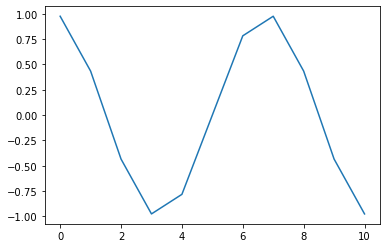

In [154]:
pivoted_df.loc[:10,'sin(1,freq=W-SUN)'].plot();

## Plots + Questions

In [155]:
# pd.concat([pivoted_df['mood'] - pivoted_df['mood_prev1'], pivoted_df['mood_change']], axis=1).rename(columns={0: 'mood_change'}).corr()

In [156]:
# # strong weekly seasonality of mood
# pivoted_df.groupby('day_name').mean()['mood'].plot(ylabel='avg mood');

In [157]:
# # screen time of apps does not ad up to screen column
# %matplotlib inline
# apps =  ['appCat.builtin', 'appCat.communication',
#        'appCat.entertainment', 'appCat.finance', 'appCat.game',
#        'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
#        'appCat.unknown', 'appCat.utilities', 'appCat.weather']
# pivoted_df['screen_sum'] = pivoted_df[apps].sum(axis=1)
# pivoted_df[['screen','screen_sum']]
# (pivoted_df['screen'] - pivoted_df['screen_sum']).plot(figsize=(18,8 ), title='screen - sum(apps)');

### Value for activity missing in more than 14% of the rows!!!
there should be an entry for every hour\
Phone turned off when no data???
currently day deleted if no data for more than 6 hours

## Train-test split

In [158]:
from sklearn.model_selection import train_test_split#, StratifiedKFold

as we are going to predict in the feature, we will be able to train ML models only in the past

In [159]:
#pivoted_df['mood'].value_counts()

In [160]:
#pivoted_df['mood_next'] = round(pivoted_df['mood_next'])
#pivoted_df['mood_next'].hist();

In [161]:
pivoted_df.id.value_counts()

AS14.26    67
AS14.08    61
AS14.17    55
AS14.15    54
AS14.24    54
AS14.05    52
AS14.16    52
AS14.13    52
AS14.07    47
AS14.20    46
AS14.01    46
AS14.03    46
AS14.30    46
AS14.09    45
AS14.19    45
AS14.06    44
AS14.14    43
AS14.31    42
AS14.33    42
AS14.27    41
AS14.29    41
AS14.12    40
AS14.02    40
AS14.23    38
AS14.28    37
AS14.32    36
AS14.25    29
Name: id, dtype: int64

In [173]:
# Separetely split train and test for each user
pivoted_df.sort_values(['id','time'], inplace=True)
pivoted_df.drop(['time'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = pd.DataFrame(), pd.DataFrame(), pd.Series(), pd.Series()
for idx in pivoted_df['id'].unique():
#     X = pivoted_df[pivoted_df['id'] == idx].drop(['mood_next', 'day_name'], axis=1)
    X = pivoted_df[pivoted_df['id'] == idx].drop(['next_mood'], axis=1)
    y = pivoted_df[pivoted_df['id'] == idx]['next_mood']
    X_train_idx, X_test_idx, y_train_idx, y_test_idx = train_test_split(X, y, train_size=0.7, shuffle=False)
    X_train = pd.concat([X_train, X_train_idx])
    X_test = pd.concat([X_test, X_test_idx])
    y_train = pd.concat([y_train, y_train_idx])
    y_test = pd.concat([y_test, y_test_idx])
    
#X_test.reset_index(inplace=True, drop=True)
#y_test.reset_index(inplace=True, drop=True)

In [174]:
X_train.shape, X_test.shape

((856, 35), (385, 35))

In [175]:
X_train.head()

id      mood  circumplex.arousal  circumplex.valence  activity  \
0  AS14.01  6.250000               -0.25            0.750000  0.000000   
1  AS14.01  6.333333                0.00            0.333333  0.000000   
2  AS14.01  6.200000                0.20            0.200000  3.083152   
3  AS14.01  6.400000                0.60            0.500000  3.790084   
4  AS14.01  6.800000                0.20            0.800000  2.141117   

   appCat.builtin  appCat.communication  appCat.entertainment  appCat.finance  \
0        0.000000              0.000000                0.0000        0.000000   
1        0.000000              0.000000                0.0000        0.000000   
2      230.019006            763.079384              349.7113       12.334933   
3      138.338687            882.779741               46.6620        7.025333   
4      145.124771            746.957427               49.1870       10.850750   

   appCat.game  appCat.office  appCat.other  appCat.social  appCat.travel  \
0          0.0         0.0000         0.000       0.000000        0.00000   
1          0.0         0.0000         0.000       0.000000        0.00000   
2          0.0       117.2435       193.873    1214.028518      314.31275   
3          0.0         0.0000        98.143     205.970250       37.30500   
4          0.0         0.0000        72.823     369.885567        0.00000   

   appCat.unknown  appCat.utilities  appCat.weather  call       screen  sms  \
0             0.0          0.000000           0.000   1.0     0.000000  2.0   
1             0.0          0.000000           0.000   0.0     0.000000  0.0   
2             0.0        197.625786           0.000   4.0  3566.876103  0.0   
3             0.0        117.621000           0.000   2.0   656.267264  1.0   
4             0.0         30.086000          30.386   0.0   974.988754  0.0   

   asleep  active  missing_hour  prev_mood  sin(1,freq=W-SUN)  \
0     0.0     0.0          24.0   0.000000           0.974928   
1     0.0     0.0          24.0   6.250000           0.433884   
2     7.0     2.0           1.0   6.333333          -0.433884   
3     1.0     2.0           8.0   6.200000          -0.974928   
4     1.0     0.0           9.0   6.400000          -0.781831   

   cos(1,freq=W-SUN)  sin(2,freq=W-SUN)  cos(2,freq=W-SUN)  sin(3,freq=W-SUN)  \
0          -0.222521          -0.433884          -0.900969          -0.781831   
1          -0.900969          -0.781831           0.623490           0.974928   
2          -0.900969           0.781831           0.623490          -0.974928   
3          -0.222521           0.433884          -0.900969           0.781831   
4           0.623490          -0.974928          -0.222521          -0.433884   

   cos(3,freq=W-SUN)  day  dayofweek  is_weekend  dayofyear  quarter  
0           0.623490   26          2           0         57        1  
1          -0.222521   27          3           0         58        1  
2          -0.222521   21          4           0         80        1  
3           0.623490   22          5           1         81        1  
4          -0.900969   23          6           1         82        1

Such kind of split is not totally fair from the time-series perspective as for some users we predict for the days which were included as train for the others. This may leak time-related peculiarities 

## Feature engineering

### Categoricals

ID may be encoded in advance as we do not expect new users during test period

In [176]:
enc = ce.OneHotEncoder(cols=['id'], 
                       use_cat_names=True)

X_train = enc.fit_transform(X_train)
print('X_train.shape', X_train.shape)
X_train.head(3)

X_train.shape (856, 61)


id_AS14.01  id_AS14.02  id_AS14.03  id_AS14.05  id_AS14.06  id_AS14.07  \
0           1           0           0           0           0           0   
1           1           0           0           0           0           0   
2           1           0           0           0           0           0   

   id_AS14.08  id_AS14.09  id_AS14.12  id_AS14.13  id_AS14.14  id_AS14.15  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   

   id_AS14.16  id_AS14.17  id_AS14.19  id_AS14.20  id_AS14.23  id_AS14.24  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   

   id_AS14.25  id_AS14.26  id_AS14.27  id_AS14.28  id_AS14.29  id_AS14.30  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   

   id_AS14.31  id_AS14.32  id_AS14.33      mood  circumplex.arousal  \
0           0           0           0  6.250000               -0.25   
1           0           0           0  6.333333                0.00   
2           0           0           0  6.200000                0.20   

   circumplex.valence  activity  appCat.builtin  appCat.communication  \
0            0.750000  0.000000        0.000000              0.000000   
1            0.333333  0.000000        0.000000              0.000000   
2            0.200000  3.083152      230.019006            763.079384   

   appCat.entertainment  appCat.finance  appCat.game  appCat.office  \
0                0.0000        0.000000          0.0         0.0000   
1                0.0000        0.000000          0.0         0.0000   
2              349.7113       12.334933          0.0       117.2435   

   appCat.other  appCat.social  appCat.travel  appCat.unknown  \
0         0.000       0.000000        0.00000             0.0   
1         0.000       0.000000        0.00000             0.0   
2       193.873    1214.028518      314.31275             0.0   

   appCat.utilities  appCat.weather  call       screen  sms  asleep  active  \
0          0.000000             0.0   1.0     0.000000  2.0     0.0     0.0   
1          0.000000             0.0   0.0     0.000000  0.0     0.0     0.0   
2        197.625786             0.0   4.0  3566.876103  0.0     7.0     2.0   

   missing_hour  prev_mood  sin(1,freq=W-SUN)  cos(1,freq=W-SUN)  \
0          24.0   0.000000           0.974928          -0.222521   
1          24.0   6.250000           0.433884          -0.900969   
2           1.0   6.333333          -0.433884          -0.900969   

   sin(2,freq=W-SUN)  cos(2,freq=W-SUN)  sin(3,freq=W-SUN)  cos(3,freq=W-SUN)  \
0          -0.433884          -0.900969          -0.781831           0.623490   
1          -0.781831           0.623490           0.974928          -0.222521   
2           0.781831           0.623490          -0.974928          -0.222521   

   day  dayofweek  is_weekend  dayofyear  quarter  
0   26          2           0         57        1  
1   27          3           0         58        1  
2   21          4           0         80        1

In [177]:
X_test = enc.transform(X_test)
X_test.tail(2)

id_AS14.01  id_AS14.02  id_AS14.03  id_AS14.05  id_AS14.06  id_AS14.07  \
1239           0           0           0           0           0           0   
1240           0           0           0           0           0           0   

      id_AS14.08  id_AS14.09  id_AS14.12  id_AS14.13  id_AS14.14  id_AS14.15  \
1239           0           0           0           0           0           0   
1240           0           0           0           0           0           0   

      id_AS14.16  id_AS14.17  id_AS14.19  id_AS14.20  id_AS14.23  id_AS14.24  \
1239           0           0           0           0           0           0   
1240           0           0           0           0           0           0   

      id_AS14.25  id_AS14.26  id_AS14.27  id_AS14.28  id_AS14.29  id_AS14.30  \
1239           0           0           0           0           0           0   
1240           0           0           0           0           0           0   

      id_AS14.31  id_AS14.32  id_AS14.33  mood  circumplex.arousal  \
1239           0           0           1   7.0           -1.333333   
1240           0           0           1   6.8           -0.800000   

      circumplex.valence  activity  appCat.builtin  appCat.communication  \
1239                 1.0  4.064507       91.483901               363.487   
1240                -0.4  4.050925      202.897677               565.491   

      appCat.entertainment  appCat.finance  appCat.game  appCat.office  \
1239            136.738000             0.0          0.0            0.0   
1240            169.543333             0.0          0.0            0.0   

      appCat.other  appCat.social  appCat.travel  appCat.unknown  \
1239        29.202      548.20500       0.939000           0.000   
1240        52.610      592.05377     294.840214           5.559   

      appCat.utilities  appCat.weather  call       screen  sms  asleep  \
1239          3.199000             0.0   4.0  2494.684556  1.0    13.0   
1240         36.058636             0.0   3.0  1887.579810  0.0     7.0   

      active  missing_hour  prev_mood  sin(1,freq=W-SUN)  cos(1,freq=W-SUN)  \
1239     1.0           0.0        8.2           0.433884          -0.900969   
1240     3.0           3.0        7.0          -0.433884          -0.900969   

      sin(2,freq=W-SUN)  cos(2,freq=W-SUN)  sin(3,freq=W-SUN)  \
1239          -0.781831            0.62349           0.974928   
1240           0.781831            0.62349          -0.974928   

      cos(3,freq=W-SUN)  day  dayofweek  is_weekend  dayofyear  quarter  
1239          -0.222521   29          3           0        149        2  
1240          -0.222521   30          4           0        150        2

### Normalising

In [178]:
# MinMax scale features
mm_scaler = MinMaxScaler()
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

In [179]:
pd.DataFrame(X_train_scaled, columns=X_train.columns)

id_AS14.01  id_AS14.02  id_AS14.03  id_AS14.05  id_AS14.06  id_AS14.07  \
0           1.0         0.0         0.0         0.0         0.0         0.0   
1           1.0         0.0         0.0         0.0         0.0         0.0   
2           1.0         0.0         0.0         0.0         0.0         0.0   
3           1.0         0.0         0.0         0.0         0.0         0.0   
4           1.0         0.0         0.0         0.0         0.0         0.0   
5           1.0         0.0         0.0         0.0         0.0         0.0   
6           1.0         0.0         0.0         0.0         0.0         0.0   
7           1.0         0.0         0.0         0.0         0.0         0.0   
8           1.0         0.0         0.0         0.0         0.0         0.0   
9           1.0         0.0         0.0         0.0         0.0         0.0   
10          1.0         0.0         0.0         0.0         0.0         0.0   
11          1.0         0.0         0.0         0.0         0.0         0.0   
12          1.0         0.0         0.0         0.0         0.0         0.0   
13          1.0         0.0         0.0         0.0         0.0         0.0   
14          1.0         0.0         0.0         0.0         0.0         0.0   
15          1.0         0.0         0.0         0.0         0.0         0.0   
16          1.0         0.0         0.0         0.0         0.0         0.0   
17          1.0         0.0         0.0         0.0         0.0         0.0   
18          1.0         0.0         0.0         0.0         0.0         0.0   
19          1.0         0.0         0.0         0.0         0.0         0.0   
20          1.0         0.0         0.0         0.0         0.0         0.0   
21          1.0         0.0         0.0         0.0         0.0         0.0   
22          1.0         0.0         0.0         0.0         0.0         0.0   
23          1.0         0.0         0.0         0.0         0.0         0.0   
24          1.0         0.0         0.0         0.0         0.0         0.0   
25          1.0         0.0         0.0         0.0         0.0         0.0   
26          1.0         0.0         0.0         0.0         0.0         0.0   
27          1.0         0.0         0.0         0.0         0.0         0.0   
28          1.0         0.0         0.0         0.0         0.0         0.0   
29          1.0         0.0         0.0         0.0         0.0         0.0   
30          1.0         0.0         0.0         0.0         0.0         0.0   
31          1.0         0.0         0.0         0.0         0.0         0.0   
32          0.0         1.0         0.0         0.0         0.0         0.0   
33          0.0         1.0         0.0         0.0         0.0         0.0   
34          0.0         1.0         0.0         0.0         0.0         0.0   
35          0.0         1.0         0.0         0.0         0.0         0.0   
36          0.0         1.0         0.0         0.0         0.0         0.0   
37          0.0         1.0         0.0         0.0         0.0         0.0   
38          0.0         1.0         0.0         0.0         0.0         0.0   
39          0.0         1.0         0.0         0.0         0.0         0.0   
40          0.0         1.0         0.0         0.0         0.0         0.0   
41          0.0         1.0         0.0         0.0         0.0         0.0   
42          0.0         1.0         0.0         0.0         0.0         0.0   
43          0.0         1.0         0.0         0.0         0.0         0.0   
44          0.0         1.0         0.0         0.0         0.0         0.0   
45          0.0         1.0         0.0         0.0         0.0         0.0   
46          0.0         1.0         0.0         0.0         0.0         0.0   
47          0.0         1.0         0.0         0.0         0.0         0.0   
48          0.0         1.0         0.0         0.0         0.0         0.0   
49          0.0         1.0         0.0         0.0    

## Correlations

## Save preprocessed data

In [186]:
import os

In [187]:
data_path = 'data'

In [189]:
X_train.to_csv(os.path.join(data_path, 'X_train.csv'))
y_train.to_csv(os.path.join(data_path, 'y_train.csv'))

X_test.to_csv(os.path.join(data_path, 'X_test.csv'))
y_test.to_csv(os.path.join(data_path, 'y_test.csv'))

In [193]:
pd.DataFrame(X_train_scaled, columns=X_train.columns).to_csv(os.path.join(data_path, 'X_train_minmax_scaled.csv'))
pd.DataFrame(X_test_scaled, columns=X_test.columns).to_csv(os.path.join(data_path, 'X_test_minmax_scaled.csv'))